# Showcase of a project to automatically solve a sudoku, with an image as input.

We start with imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
 
from mnist import Net
from PIL import Image
from IPython.display import display
from utils import display_image, compute_image_sum, read_image, overlay_board, display_image_notebook
from get_sudoku import get_board, preprocess_image, process_number_cell
from functions import draw_sudoku
from sudoku_solver import solve_sudoku


Now we read in the image of the sudoku board

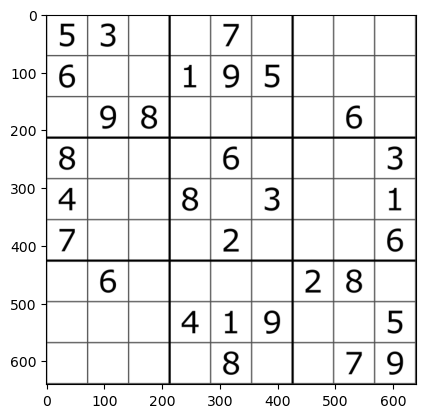

In [2]:
image = read_image("images/sudoku.png")
fig, ax = plt.subplots()
ax.imshow(image)
plt.show()


# Now we do some pre-processing to find the board contours
#### We also warps the perspective of the board and downscales it, to better fit with the classification network

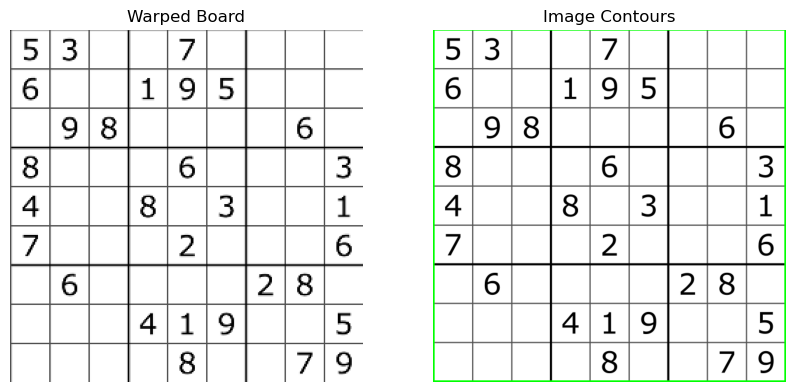

In [3]:
img_contours, warped_board, original_position = preprocess_image(image)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(warped_board.astype(np.uint8))
axes[0].set_title('Warped Board')
axes[0].axis('off')
axes[1].imshow(img_contours.transpose(1,2,0).astype(np.uint8))
axes[1].set_title('Image Contours')
axes[1].axis('off')

plt.show()



# Now we divide the board into 81 different images, 1 for each cell.

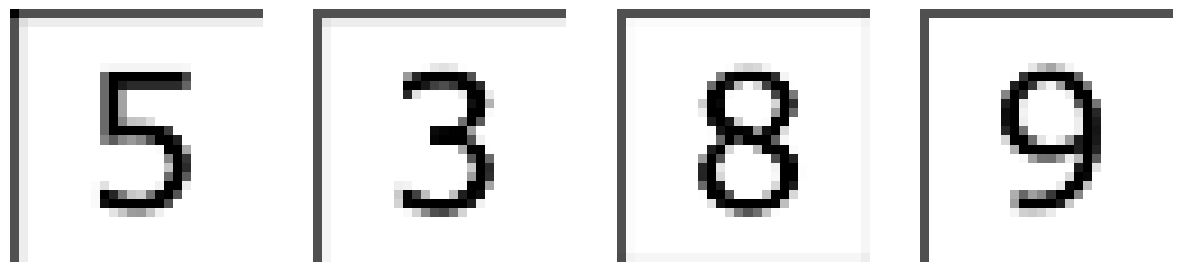

In [4]:
cell_size = warped_board.shape[0] // 9
cells = np.array([np.hsplit(row, 9) for row in np.vsplit(warped_board, 9)])
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
image_arrays = [cells[0,0,...], cells[0,1,...], cells[2,2,...], cells[8,8,...]]
for ax, image_array in zip(axes, image_arrays):
    ax.imshow(image_array)
    ax.axis('off')
plt.show()


# Each of these images are pre-processed to create images more alike the ones in MNIST. 

#### This is beacuse a classifier trained on the MNIST data-set is used to classify each digit

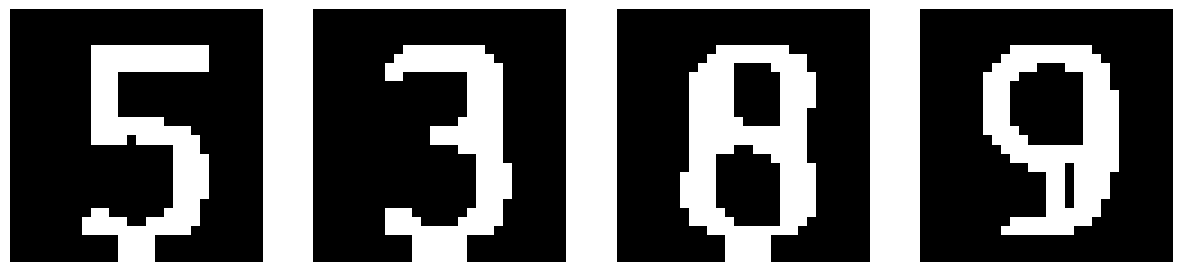

In [5]:
binary_0_0 = process_number_cell(cells[0,0,...], size=(28, 28)).numpy()
binary_0_1 = process_number_cell(cells[0,1,...], size=(28, 28)).numpy()
binary_2_2 = process_number_cell(cells[2,2,...], size=(28, 28)).numpy()
binary_8_8 = process_number_cell(cells[8,8,...], size=(28, 28)).numpy()
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
image_arrays = [binary_0_0.transpose(1,2,0), binary_0_1.transpose(1,2,0), binary_2_2.transpose(1,2,0), binary_8_8.transpose(1,2,0)]
for ax, image_array in zip(axes, image_arrays):
    ax.imshow(image_array,cmap='gray')
    ax.axis('off')
plt.show()



# Now let's loop over all cells and if they have more than 50 pixels with white cells, let a classifier compute what digit it is.

#### Lets take a look at the network being used

- the training of the network can be found in mnist.py

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
modelcnn = Net()
modelcnn.load_state_dict(torch.load("models/mnist_cnn.pt"))
modelcnn.eval()
softmax = nn.Softmax(dim=1)
board = np.zeros([9,9])
for i in range(9):
        for j in range(9):
            number_cell = cells[i, j, :, :, :]
            t_number_rgb = process_number_cell(number_cell, size=(28, 28)).unsqueeze(0)
            if compute_image_sum(t_number_rgb[0]) > 50:
                output = modelcnn(t_number_rgb)
                probabilities = softmax(output)
                predictions = probabilities.argmax(dim=1)
            else:
                predictions = torch.tensor(0)

            board[i,j] = int(predictions.item())


## Let's look at the result, and compare to the image

- - - - - - - - - - - - 
5.0 3.0 4.0  | 6.0 7.0 8.0  | 9.0 1.0 2.0
6.0 7.0 2.0  | 1.0 9.0 5.0  | 3.0 4.0 8.0
1.0 9.0 8.0  | 3.0 4.0 2.0  | 5.0 6.0 7.0
- - - - - - - - - - - - 
8.0 5.0 9.0  | 7.0 6.0 1.0  | 4.0 2.0 3.0
4.0 2.0 6.0  | 8.0 5.0 3.0  | 7.0 9.0 1.0
7.0 1.0 3.0  | 9.0 2.0 4.0  | 8.0 5.0 6.0
- - - - - - - - - - - - 
9.0 6.0 1.0  | 5.0 3.0 7.0  | 2.0 8.0 4.0
2.0 8.0 7.0  | 4.0 1.0 9.0  | 6.0 3.0 5.0
3.0 4.0 5.0  | 2.0 8.0 6.0  | 1.0 7.0 9.0
- - - - - - - - - - - - 


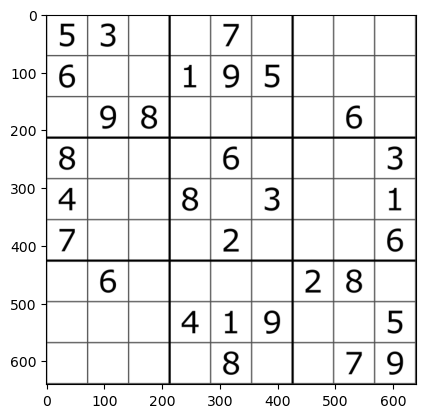

In [16]:
draw_sudoku(board)
image = read_image("images/sudoku.png")
fig, ax = plt.subplots()
ax.imshow(image)
plt.savefig("results/original.png")
plt.show()


# Now we have a digital represenation of the board, it is time to solve it!

In [10]:
original_board = board.copy()
solve_sudoku(board,0,0)

draw_sudoku(original_board)
draw_sudoku(board)

- - - - - - - - - - - - 
5.0 3.0 0.0  | 0.0 7.0 0.0  | 0.0 0.0 0.0
6.0 0.0 0.0  | 1.0 9.0 5.0  | 0.0 0.0 0.0
0.0 9.0 8.0  | 0.0 0.0 0.0  | 0.0 6.0 0.0
- - - - - - - - - - - - 
8.0 0.0 0.0  | 0.0 6.0 0.0  | 0.0 0.0 3.0
4.0 0.0 0.0  | 8.0 0.0 3.0  | 0.0 0.0 1.0
7.0 0.0 0.0  | 0.0 2.0 0.0  | 0.0 0.0 6.0
- - - - - - - - - - - - 
0.0 6.0 0.0  | 0.0 0.0 0.0  | 2.0 8.0 0.0
0.0 0.0 0.0  | 4.0 1.0 9.0  | 0.0 0.0 5.0
0.0 0.0 0.0  | 0.0 8.0 0.0  | 0.0 7.0 9.0
- - - - - - - - - - - - 
- - - - - - - - - - - - 
5.0 3.0 4.0  | 6.0 7.0 8.0  | 9.0 1.0 2.0
6.0 7.0 2.0  | 1.0 9.0 5.0  | 3.0 4.0 8.0
1.0 9.0 8.0  | 3.0 4.0 2.0  | 5.0 6.0 7.0
- - - - - - - - - - - - 
8.0 5.0 9.0  | 7.0 6.0 1.0  | 4.0 2.0 3.0
4.0 2.0 6.0  | 8.0 5.0 3.0  | 7.0 9.0 1.0
7.0 1.0 3.0  | 9.0 2.0 4.0  | 8.0 5.0 6.0
- - - - - - - - - - - - 
9.0 6.0 1.0  | 5.0 3.0 7.0  | 2.0 8.0 4.0
2.0 8.0 7.0  | 4.0 1.0 9.0  | 6.0 3.0 5.0
3.0 4.0 5.0  | 2.0 8.0 6.0  | 1.0 7.0 9.0
- - - - - - - - - - - - 


# It is a bit hard to see the results, let's vizulise it a bit better

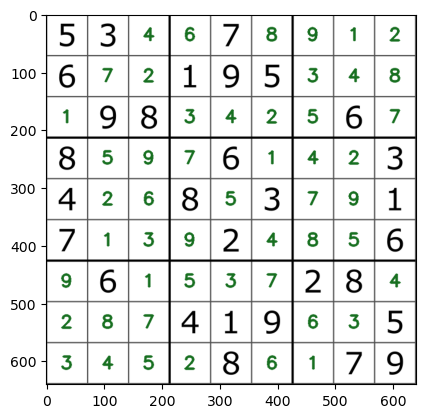

In [15]:
overlayed_board = overlay_board(image, original_board, board, original_position)
fig, ax = plt.subplots()
ax.imshow(overlayed_board)
plt.savefig("results/solved.png")
plt.show()